<a href="https://colab.research.google.com/github/avk4714/DL_Projects/blob/master/dropout_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a test implementation of the **Dropout as a Bayesian Approximation methods** by *Gal et al.* from University of Cambridge. The implementation has been made with reference to the paper and video posted by the channel **Viking Penguin** on YouTube.

**1. Define the class for this Dropout method**

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Bernoulli
import matplotlib.pyplot as plt


**2. Building the PyTorch Network Model**

In [0]:
class Net(nn.Module):
  def __init__(self, D_in1, n_hidden, D_out1, z_prob1, lam_mult1):
    super(Net, self).__init__()
    # Layers
    # self.model_L_1 = DBA(D_in1, n_hidden, z_prob1, lam_mult1)
    # self.model_L_2 = DBA(n_hidden, n_hidden, z_prob1, lam_mult1)
    # self.model_L_3 = DBA(n_hidden, D_out1, z_prob1, lam_mult1)
    self.model_L_1 = torch.nn.Linear(D_in1, n_hidden, bias=True)
    self.model_D_1 = torch.nn.Dropout(p=0.5)
    self.model_L_2 = torch.nn.Linear(n_hidden, n_hidden, bias=True)
    self.model_D_2 = torch.nn.Dropout(p=0.5)
    self.model_L_3 = torch.nn.Linear(n_hidden, n_hidden, bias=True)
    self.model_D_3 = torch.nn.Dropout(p=0.5)
    self.model_L_4 = torch.nn.Linear(n_hidden, D_out1, bias=True)

  def forward(self, x):
    pred_1 = F.relu(self.model_D_1(self.model_L_1(x)))
    pred_2 = F.relu(self.model_D_2(self.model_L_2(pred_1)))
    pred_3 = F.relu(self.model_D_3(self.model_L_3(pred_2)))
    y_pred = self.model_L_4(pred_3)
    return y_pred


**3. Initialization and Training**

1


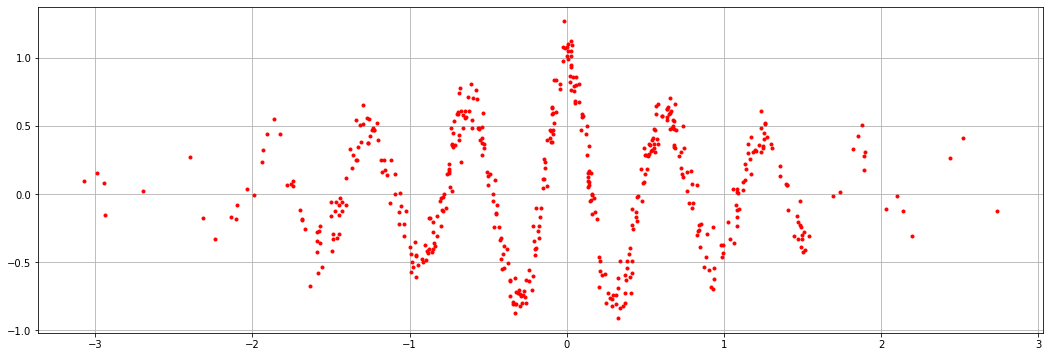

In [103]:
X = Variable(torch.randn(500, 1))
y_t = np.random.normal(np.cos(10. * X) / (np.abs(X) + 1.), 0.1)
# y_tt = Variable(torch.normal(mean=np.cos(10. * X) / (np.abs(X) + 1.),std=0.05))
print(X.shape[1])
if True:
  plt.figure(figsize=(18,6))
  plt.plot(X, y_t, "r.")
  # plt.plot(X, y_tt, "b^")
  plt.grid()
  plt.show()


In [104]:
''' Call the NN and train from here onwards '''
# Sample data.
n_samples = 500
n_hidden = 1000
z_prob = 0.5
lam_mult = 1e-2
d_in = 1
d_out = 1
X = Variable(torch.randn(n_samples, d_in))
y = Variable(torch.normal(mean=np.cos(10. * X) / (np.abs(X) + 1.),std=0.1), requires_grad=False)

X_pred = np.atleast_2d(np.linspace(-3., 3., num=100)).T
X = torch.from_numpy(np.hstack((X, X**2, X**3)))
X_pred = torch.from_numpy(np.hstack((X_pred, X_pred**2, X_pred**3)))


# PyTorch Model.
model = Net(d_in * 3, n_hidden, d_out, z_prob, lam_mult)

# Loss function and Optimizer
criterion1 = torch.nn.MSELoss(size_average=False)
# criterion2 = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=lam_mult)

# Training runs
loss_data = []
for t in range(2000):
  y_pred = model(X)

  loss = criterion1(y_pred, y)

  if t % 100 == 99:
    loss_data.append([t, loss.item()])
    print(t, loss.item())
  
  # zero gradients, perform a backward pass and update the weights
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()



/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


99 102.49881744384766
199 59.68802261352539
299 38.30686950683594
399 29.86163330078125
499 23.185855865478516
599 20.861804962158203
699 20.746971130371094
799 16.990915298461914
899 17.191194534301758
999 16.122962951660156
1099 15.357516288757324
1199 15.067511558532715
1299 17.741466522216797
1399 15.566448211669922
1499 13.906881332397461
1599 14.268392562866211
1699 13.874967575073242
1799 14.279032707214355
1899 14.102402687072754
1999 14.76116943359375


**4.1. Visualize Data**

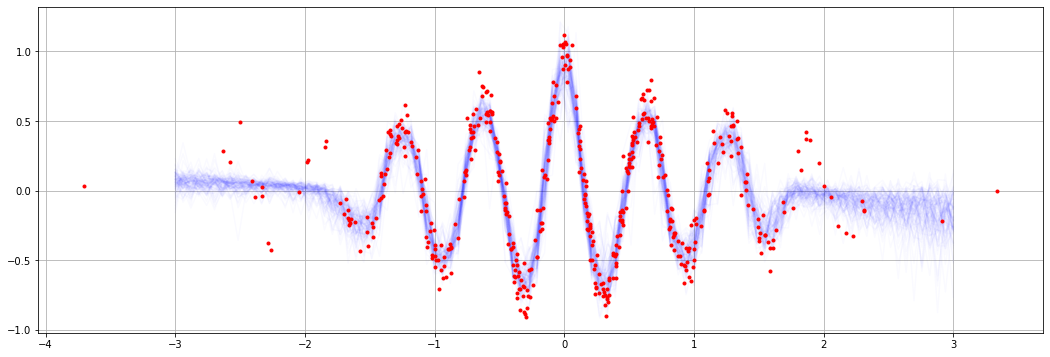

In [105]:
# Y_post = torch.zeros((100,X_pred.shape[0]))
# for tt in range(100):
X_pred2 = np.atleast_2d(np.linspace(-3.,3.,num=100)).T
X_pred2 = torch.from_numpy(np.hstack((X_pred2, X_pred2**2, X_pred2**3)))

if True:
  plt.figure(figsize=(18,6)) 
  # print(X_pred2.size())
  mu_ypred = []
  var_ypred = []
  Y_comb = torch.empty([100,1])
  # print(Y_comb.size())
  for i in range(100):
    Y_post = model(X_pred2.float())
    # print(Y_post.size())
    Y_comb = torch.cat((Y_comb,Y_post),dim=-1)
    plt.plot(X_pred2[:,0], Y_post.detach().numpy(),"b-",alpha=1./50)
  plt.plot(X[:,0], y, "r.")
  plt.grid()
  plt.show()
  # Calculate mean and variance vectors for the data
  for j in range(100):
    mu_ypred.append(np.mean(Y_comb[j].detach().numpy()))
    var_ypred.append(np.var(Y_comb[j].detach().numpy()))

  mu_ypred_arr = np.array(mu_ypred).reshape(100,1)
  var_ypred_arr = np.array(var_ypred).reshape(100,1)

**4.2. Visualize Loss over Time**

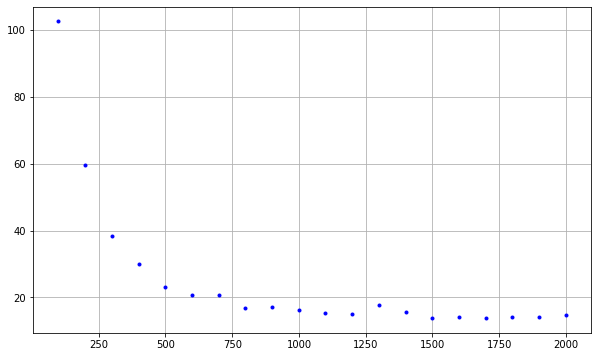

In [106]:
plt.figure(figsize=(10,6)) 
for t,l in loss_data:
  plt.plot(t,l,"b.")
plt.grid()
plt.show()

**Sandbox Section**

In [73]:
a1 = torch.tensor(([3],[2],[1]))
a2 = torch.tensor(([4],[2],[4]))
a3 = torch.cat((a1,a2),dim=1)
print(a3)
mu_a3 = []
var_a3 = []
for i in range(3):
  mu_a3.append(np.mean(a3[i].numpy()))
  var_a3.append(np.var(a3[i].numpy()))
mu_a3_arr = np.array(mu_a3).reshape([3,1])
var_a3_arr = np.array(var_a3).reshape([3,1])
print(mu_a3_arr, var_a3_arr)

tensor([[3, 4],
        [2, 2],
        [1, 4]])
[[3.5]
 [2. ]
 [2.5]] [[0.25]
 [0.  ]
 [2.25]]
